### Trend Filtering Summary

**Overview**:
- The method is used to estimate trends in data observed at evenly spaced input points $x = (x_1, \dots, x_n)$, corresponding to output points $y = (y_1, \dots, y_n)$.
- The trend filtering estimate $\hat{\beta} = (\hat{\beta}_1, \dots, \hat{\beta}_n)$ of order $k \geq 0$ is obtained by solving the following optimization problem:

$$
\hat{\beta} = \arg\min_{\beta \in \mathbb{R}^n} \left( \frac{1}{2} \| y - \beta \|_2^2 + \lambda \| D^{(k+1)} \beta \|_1 \right)
$$

- Here, $\lambda \geq 0$ is a tuning parameter, and $D^{(k+1)} \in \mathbb{R}^{(n-k) \times n}$ is the discrete difference (or derivative) operator of order $k+1$.

**Difference Operator**:
- The first-order difference matrix $D^{(1)}$ is defined as:

$$
D^{(1)} = \begin{bmatrix}
-1 & 1 & 0 & \dots & 0 & 0\\
0 & -1 & 1 & \dots & 0 & 0\\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
0 & 0 & 0 & \dots & -1 & 1 \\
\end{bmatrix}
$$

- Higher-order difference operators $D^{(k+1)}$ are defined recursively:

$$
D^{(k+1)} = D^{(1)} D^{(k)}
$$



**Objective**:
- The paper introduces a new algorithm for solving the trend filtering problem efficiently, with a focus on computational aspects rather than model selection.
- The paper does not address how to choose the tuning parameter \( \lambda \), which is a common challenge in regularized estimation methods.
- The goal is to provide a scalable and efficient method for solving the trend filtering problem for any given \( \lambda \), or sequence of \( \lambda \) values.

**Existing Algorithms**:
- For **0th order trend filtering** (the 1D fused lasso problem), there are already two direct, linear-time algorithms:
  1. **Taut String Principle** (Davies & Kovac, 2001).
  2. **Dynamic Programming Approach** (Johnson, 2013).
- Both algorithms are highly efficient and accurate, making them superior for the 0th order case.
- However, these algorithms cannot be directly extended to higher order cases ( $k = 1, 2, 3, \dots $).

**New Approach**:
- The proposed method indirectly extends the powerful 0th order algorithms to higher order cases by using a special implementation of the **Alternating Direction Method of Multipliers (ADMM)**.

**Comparison to Existing Methods**:
- The **Primal-Dual Interior Point (PDIP) Method** by Kim et al. (2009) is currently the preferred method for computing trend filtering estimates.
  - PDIP is efficient because it involves solving banded linear systems, as the discrete difference operators are banded.
- The specialized ADMM implementation and the PDIP method each have their own distinct strengths.


#### **Standard ADMM Method**
rewriting problem as:

$$
\min_{\beta \in \mathbb{R}^n, \alpha \in \mathbb{R}^{n-k-1}} \frac{1}{2} \| y - \beta \|_2^2 + \lambda \| \alpha \|_1 \quad \\
\text{s.t.} \quad \alpha = D^{(k+1)}\beta.
$$

The augmented Lagrangian can then be written as:

$$
L(\beta, \alpha, u) = \frac{1}{2} \| y - \beta \|_2^2 + \lambda \| \alpha \|_1 + \frac{\rho}{2} \| \alpha - D^{(k+1)}\beta + u \|_2^2 - \frac{\rho}{2} \| u \|_2^2,
$$

---
#### Standard ADMM updates:
---
   $$
   \beta \leftarrow (I + \rho (D^{(k+1)})^T D^{(k+1)})^{-1}(y + \rho (D^{(k+1)})^T (\alpha + u)),
   $$

   $$
   \alpha \leftarrow S_{\lambda/\rho}(D^{(k+1)}\beta - u),
   $$

   $$
   u \leftarrow u + \alpha - D^{(k+1)}\beta.
   $$

   where $I$ is the identity matrix and $\rho$ is the penalty parameter. $S_{\lambda/\rho}$ is the soft-thresholding operator.

### Specialized ADMM Approach

Our specialized ADMM approach begins by rewriting problem (1) as:

$$
\min_{\beta \in \mathbb{R}^n, \alpha \in \mathbb{R}^{n-k}} \frac{1}{2} \|y - \beta\|_2^2 + \lambda \|D^{(1)}\alpha\|_1 \quad \text{subject to} \quad \alpha = D^{(k)}\beta,
$$

where we have utilized the recursive property $ D^{(k+1)} = D^{(1)}D^{(k)} $.

The augmented Lagrangian for this formulation is:

$$
L(\beta, \alpha, u) = \frac{1}{2} \|y - \beta\|_2^2 + \lambda \|D^{(1)}\alpha\|_1 + \frac{\rho}{2} \|\alpha - D^{(k)}\beta + u\|_2^2 - \frac{\rho}{2} \|u\|_2^2,
$$

where $ \rho $ is the penalty parameter, and $ u $ is the dual variable.

---
#### Specialized ADMM updates:
---
   $$
   \beta \leftarrow (I + \rho (D^{(k)})^T D^{(k)})^{-1}(y + \rho (D^{(k)})^T (\alpha + u)),
   $$

   $$
   \alpha \leftarrow \arg\min_{\alpha \in \mathbb{R}^{n-k}} \frac{1}{2} \|D^{(k)}\beta - u - \alpha\|_2^2 + \frac{\lambda}{\rho} \|D^{(1)}\alpha\|_1,
   $$

   $$
   u \leftarrow u + \alpha - D^{(k)}\beta.
   $$




In [127]:
import numpy as np
import numpy.linalg as LA
import itertools
from itertools import count
from time import process_time

In [128]:
def proximal_map_of_weighted_mean_absolute_error(d,w,gamma,x):
    N=len(w)
    mu=np.zeros(N+2)
    nu=np.zeros(N+2)

    # calculate μ_i
    mu[0] = 0
    for i in range(1, N+1):
        mu[i] = np.sum(w[:i])
    mu[N+1] = mu[N]  # μN+1 = μN

    # ν_i= μN - μi-1
    for i in range(1, N+2):
        nu[i-1] = mu[N] - mu[i-1]

    for k in range(1, N + 1):  # 1 ≤ k ≤ N
        condition = gamma * (mu[k] - nu[k]) + d[k-1] - x
        if condition >= 0:
            break
    # ruturn min{d_k-1, x - gamma(μ_k - ν_k)}
    if k == N+1:
        return x-gamma * (mu[k-1] - nu[k-1])
    else:
        return min(x-gamma * (mu[k-1] - nu[k-1]), d[k-1])

In [129]:
import numpy as np

def prox_wmae(x, weights, data, gamma):
    r""" evaluates the proximal map of the weighted mean absolute error function at the point x,

    .. math::
        \operatorname{prox}_{\gamma f}(x) = \argmin_{y\in\mathbb{R}} \gamma \sum_{i=1}^N w_i |y-d_i| + 1/2 (y-x)^2.

    Here, :math:`w \in \mathbb{R}^N` is a vector of non-negative :code:`weights`, and :math:`d \in \mathbb{R}^N` is a vector of :code:`data` points.
    The entries in :math:`d` must be sorted in non-decreasing order.

    This is an implementation of Algorithm 1 presented in 
    Baumgärtner, Herzog, Schmidt, Weiß: The Proximal Map of the Weighted Mean Absolute Error.

    The implementation can solve :math:`k` problems at once, which share the number :math:`N` of data points but may differ in :code:`weights`, :code:`data` and :code:`gamma`.

    Parameters
    ----------
    x : float or np.array of shape (k,)
        point of evaluation
    weights : np.array of shape (N,) or (k,N)
        weights of the mean absolute error function
    data : np.array of shape (N,) or (k,N)
        data points of the mean absolute error function
    gamma : float or np.array of shape (k,)
        value of the prox parameter

    Returns
    -------
    float or np.array of shape (k,)
        :math:`\\operatorname{prox}_{\\gamma f}(x)`
    """

    # Transform all shapes in case of a single problem.
    if len(weights.shape) == 1:
        weights = weights[np.newaxis,:]
    if len(data.shape) == 1:
        data = data[np.newaxis,:]
    if len(np.array(x).shape) == 0:
        x = np.array([x])[:,np.newaxis] 

    # Evaluate the forward and reverse cumulative weights.
    # Notice that nu[0] equals \nu_1 in the paper.
    mu = np.hstack((np.zeros((weights.shape[0],1)), np.cumsum(weights,axis=-1), np.sum(weights,axis = -1, keepdims = True)))
    nu = np.hstack((np.flip(np.cumsum(np.flip(weights, axis = -1), axis = -1), axis = -1), np.zeros((weights.shape[0],1)), np.zeros((weights.shape[0],1))))

    # Evaluate the limiting derivatives (2.7), (2.10) of the objective (2.5) at all data points.
    data_extended = np.hstack((-np.inf * np.ones((data.shape[0],1)), data, np.inf * np.ones((data.shape[0],1))))
    derivatives = ((gamma * (mu - nu).T).T + data_extended - x[:,np.newaxis]) 

    # Find the smallest index k where derivatives[k] is non-negative.
    k = np.apply_along_axis(np.searchsorted, axis = -1, arr = derivatives, side = 'left', v = 0)

    # Evaluate the proximal map according to (2.9).
    y = np.minimum(data_extended[np.arange(len(k)),k], x - gamma * (mu[np.arange(len(k)),k-1] - nu[np.arange(len(k)),k-1]))

    # Reshape the result in case of a single problem.
    if y.shape == (1,1):
        return y[0,0]
    else:
        return y

In [130]:
x = 0.6
gamma = 0.8
w = np.array([0.1, 0.7, 0.0, 0.3]) 
d = np.array([-0.2, 0.4, 0.8, 1.5])
y = prox_wmae(x, w, d, gamma)
print(y)
proximal_map_of_weighted_mean_absolute_error(d,w,gamma,x)


0.4


0.4

In [131]:
# Demonstrate a call which evaluates 3 proximal maps in parallel at a single point each.
# The number of weights and data points is N = 5.
x_vec = np.array([-1, 1, 0.5])
gamma_vec = np.array([0.1, 0.2, 0.3])
w_vec = np.array([[0.5, 0.7, 0.9, 1.5, 0.25], [0.3, 0.4, 0.5, 0.6, 0.7], [0.1, 0.11, 0.111, 0.2, 0.22]])
d_vec = np.array([[0.1, 0.2, 0.3, 0.4, 0.5], [-1, -0.3, 0.1, 1.5, 2], [0, 0.25, 0.4, 0.6, 1.5]])
print(prox_wmae(x_vec, w_vec, d_vec, gamma_vec))



[-0.615   1.02    0.5297]


In [132]:
import numpy as np
import random

#minimize 0.5*(beta - y)**2 + lamd * (|a1*beta+b1| + |a2*beta+b2| + ...|ak*beta+bk|)
#L=[[a1,b1],[a2,b2],...,[ak,bk]]
def quad_obj_comp_l1(y, lambd, L):
    k = L.shape[0]
    bound = -1 * L[:,1] / L[:,0]
    sorted_indices = np.argsort(bound)
    L_sort = L[sorted_indices]

    #location matrix
    upper_triangular_matrix = np.triu(-np.ones((k, k), dtype=float), k=0)
    upper_triangular_matrix = np.vstack([upper_triangular_matrix, np.zeros(k, dtype=float)])
    lower_triangular_matrix = np.tril(np.ones((k, k), dtype=float), k=0)
    lower_triangular_matrix = np.vstack([np.zeros(k, dtype=float), lower_triangular_matrix])
    Loc = upper_triangular_matrix + lower_triangular_matrix

    a = L_sort[:,0] * np.sign(L_sort[:,0])
    coef_beta = np.dot(Loc, a)
    symmetry = -1 * (coef_beta * lambd - y)
    possible_sol = np.concatenate((symmetry, bound))
    Sol =  np.vstack((possible_sol, np.ones(possible_sol.shape[0]))).T
    L1_mat = np.dot(Sol, L_sort.T)
    f = 0.5*(possible_sol - y)**2 + lambd * np.sum(np.abs(L1_mat), axis=1)
    ind = np.argmin(f)
    beta = possible_sol[ind]

    return beta, f[ind]


In [133]:
def convert_L_to_wd(L,lambd):
    """
    将L矩阵转换为w和d向量:
    L = [[a1, b1], [a2, b2], ..., [ak, bk]]
    转换为:
    w[i] = a[i]
    d[i] = b[i] / a[i]
    
    参数:
    L: numpy array, 形状为(k, 2)，每一行是[a_i, b_i]

    返回:
    w: numpy array, 形状为(k,)，每个元素是a_i
    d: numpy array, 形状为(k,)，每个元素是b_i / a_i
    """
    # 提取 w 和 d
    w =lambd* L[:, 0]  # w[i] =lambda *  a[i]
    d = L[:, 1] / L[:, 0]  # d[i] =b[i] / a[i]
    
    return w, d

In [134]:

def trend_filter_cd(y, k0, lambd, max_iter, eps):
    n = y.shape[0]
    beta = np.random.randn(n)
    i = 0
    criterion = 10
    numbers = list(range(n))

    #difference operator
    D1 = np.zeros((n-1,n))
    for j in range(n-1):
        D1[j,j] = -1
        D1[j,j+1] = 1
    D = D1
    for k in range(1,k0+1):
        D = np.dot(D1[:(n-k-1), :(n-k)], D)

    while i < max_iter:
        random.shuffle(numbers)
        last_beta = beta
        for j in numbers:
            non_zero_rows = D[:, j] != 0
            filtered = D[non_zero_rows]
            coefs = filtered[:,j]
            intercepts = np.dot(filtered, beta) - filtered[:,j] * beta[j]
            L = np.vstack((coefs, intercepts)).T
            w,d=convert_L_to_wd(L,lambd)
            yj = y[j] 
            beta_j = prox_wmae(yj, w, d, gamma=1)
            beta[j] = beta_j

        #criterion = sum((beta - last_beta)**2)
        i = i + 1
        loss = 0.5 * sum((y - beta)**2) + lambd * sum(abs(np.dot(D, beta)))

        if (i+1) % 100 == 0:
            print(loss)

    return beta

0.38253161379724887
0.38253161379724887
0.38253161379724887
0.38253161379724887
0.38253161379724887
0.38253161379724887
0.38253161379724887
0.38253161379724887
0.38253161379724887
0.38253161379724887


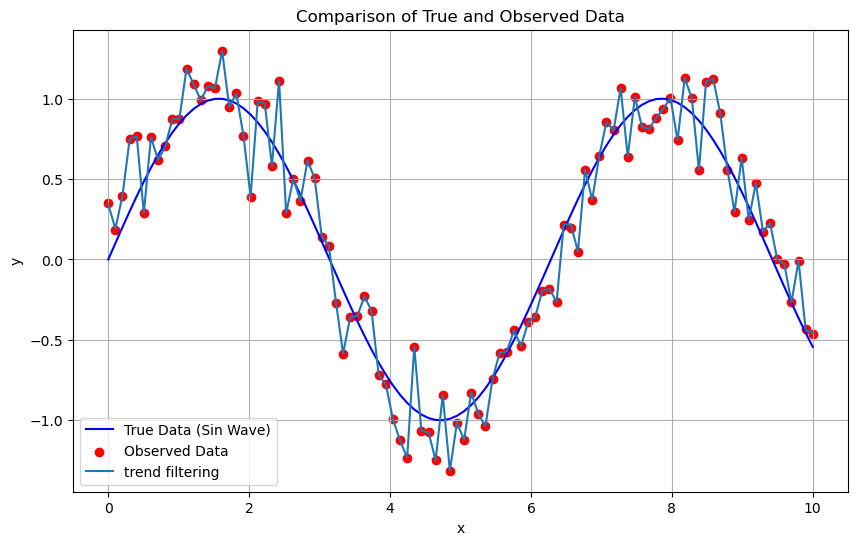

In [136]:
import matplotlib.pyplot as plt
import random

np.random.seed(0)

x = np.linspace(0, 10, 100)  
y_true = np.sin(x)        
noise = np.random.normal(0, 0.2, y_true.shape)  
y_obs = y_true + noise  

beta = trend_filter_cd(y_obs, k0=1, lambd=0.01, max_iter=1000, eps=1e-9)

plt.figure(figsize=(10, 6))
plt.plot(x, y_true, label='True Data (Sin Wave)', color='blue') 
plt.scatter(x, y_obs, color='red', label='Observed Data')    
plt.plot(x, beta, label='trend filtering')   
plt.title('Comparison of True and Observed Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()